In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy as sp

# Project's package
import sys
try:
    session_params is not None 
    sys.path.append("../auimpy")
    import prepair, air
except NameError:
    session_params = {
    'filters_applied': True,
    'minimal_accuracy': 60,
    'write_text': True,
    'save_figs': True,
    'input_method': 'mouse',
    'iters_num': 10000,
    }
    sys.path.append("../auimpy")
    import prepair, air

data = pd.read_csv('./input/exp2 - ia_ring_irrelevant.csv')
demog = pd.read_csv('./input/demog.csv')

# Participants ran with their data saved to seconds instead of milliseconds
secs_to_ms = ['2017_Jun_11_0926', '2017_Jun_11_1029', '2017_Jun_15_1034']
# Participants with RT including ISI
return_isi_and_jitter = ['2017_Jun_11_0926', '2017_Jun_11_1029', '2017_Jun_15_1034',
                           '2017_May_25_1111', '2017_May_25_1134', '2017_May_25_1336']

In [2]:
print(demog['sex'].value_counts(normalize=True))
print(demog['age'].describe())
print(demog.shape[0])

Female    0.62963
Male      0.37037
Name: sex, dtype: float64
count    27.000000
mean     25.740741
std       5.410763
min      19.000000
25%      22.000000
50%      25.000000
75%      28.000000
max      39.000000
Name: age, dtype: float64
27


In [3]:
# PRE PROCESSING

# This participant did not have all experimental blocks, for some reason.
data = data.loc[data['date'] != '2017_May_25_1043']

# Handling headline rows, breaks and Practice trials
data = data.loc[~pd.isna(data['participant']) & ~pd.isna(data['trialsExpSmallLoop.thisTrialN'])]

# Non-Unique participant numbers have to be factorized (in conjunction with date)
data['participant'] = data['participant'].astype(str).str.cat(data['date'].values, sep="_").astype('category').cat.codes.values

data.loc[data['date'].isin(secs_to_ms), data.filter(like='rt_').columns] = (
    (data.loc[data['date'].isin(secs_to_ms)].filter(like='rt_') * 1000)).values

data.loc[data['date'].isin(return_isi_and_jitter), data.filter(like='rt_').columns] = (
    data.loc[data['date'].isin(return_isi_and_jitter), data.filter(like='rt_').columns] + 500).replace({500: 0})

# Generate a numeric trial identifier
data['trial'] = data.groupby('date')['date'].cumcount().values

# RT in seconds >> RT in MS
data[data.filter(like='rt_').columns] = data.filter(like='rt_').replace(
    {0: np.nan}).values
# Find RT on trial
data['rt'] = data.filter(like='rt_').min(axis=1).subtract(
    data['jitter'], axis='index').subtract(500).values

# Find key (and finger) of rt on trial, reverse for left-handed participants
data['response'] = data.filter(like='rt_').idxmax(axis=1
            ).replace({'rt_left': 'Index', 'rt_up': 'Middle', 'rt_right': 'Ring'}).values
data.loc[(data['hand'] == 'L'.lower()) & data['response'].isin(['Index', 'Middle']), 'response'].replace(
     {'Index': 'Middle', 'Middle': 'Index'}, inplace=True)

# Handle labeling of distractor fingers
data['distrFinger'] = data['distrFinger'].str.title().values
data['distrFinger'].replace({'None': 'Baseline'}, inplace=True)

# Flag the numerical cue as index or middle finger, reverse for left-hand participants
data['number'] = data['number'].replace({1: 'Index', 2: 'Middle'}).values
data.loc[data['hand'] == 'L'.lower(), 'number'].replace(
    {'Index': 'Middle', 'Middle': 'Index'}, inplace=True)

data['condition'] = data['cond'].str.title().values

# Keep only the relevant columns for further processing of the data
data = data.drop(columns=[i for i in data.columns if i not in 
                          ['participant', 'date', 'rt', 'number', 'distrFinger', 'response', 'hand',
                          'trial', 'condition', 'jitter']])

# Label response accuracy
data['correct'] = np.where(data['number'] == data['response'], True, False)

data.rename(columns={'number': 'cuenumber'}, inplace=True)


# Place-holder since no keys at start were simply written down as negative RT
data['keys_at_start'] = '[1, 0, 1]'

In [4]:
prpr = prepair.PrepAIR(data=data, **session_params)

In [5]:
prpr.report_invalid_trials()

'Invalid trials included incorrect or omitted responses (9.86%), slow responses (>950ms, 1.95%) fast responses (<150ms, 1.23%), and trials in which participants did not press the keys down correctly in the beginning of the trial (0.0%). Finally, all data from 2 participants (<60% valid trials, 7.69% of 26) were removed. Total filtration amounted to 13.96%.'

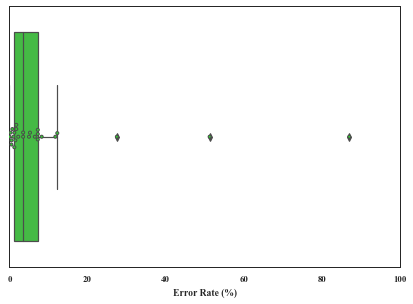

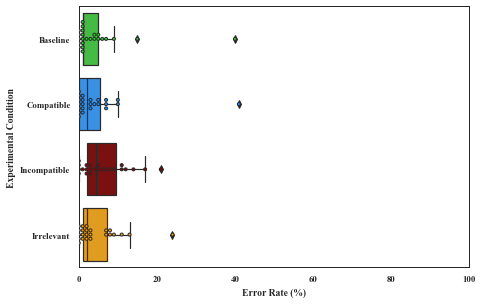

In [6]:
# Pre filteration
prpr.plot_descriptives('er', by_condition=False, pre_filteration=True)
# Post filteration
prpr.plot_descriptives('er', by_condition=True, pre_filteration=False)

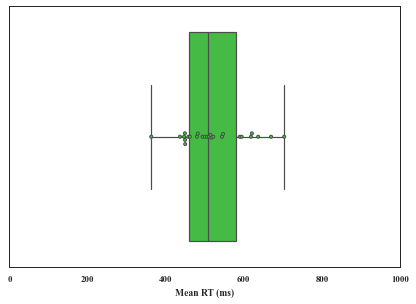

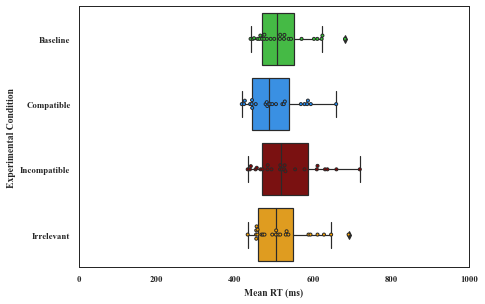

In [7]:
# Pre filteration
prpr.plot_descriptives('rt', by_condition=False, pre_filteration=True)
# Post filteration
prpr.plot_descriptives('rt', by_condition=True, pre_filteration=False)

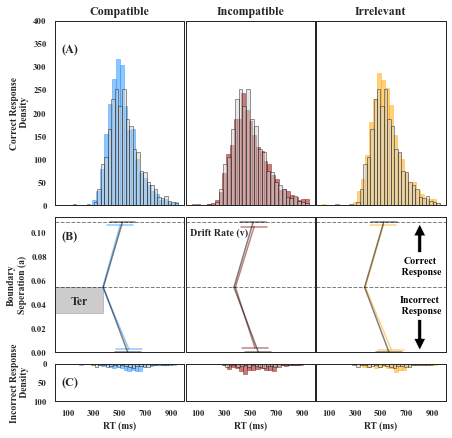

In [8]:
prpr.plot_diffusion()

In [9]:
*dfs, summary = prpr.get_finalized_data()
summary

,Mean Response Time,Error Rate,Drift Rate,Boundary Separation,Non-Decision Time
Condition (n = 24),,,,,
Baseline,520.29 (66.68),4.5 (8.36),0.348 (0.099),0.108 (0.015),373.83 (57.89)
Compatible,502.19 (64.84),4.58 (8.4),0.362 (0.101),0.103 (0.017),369.12 (53.34)
Incompatible,531.23 (78.38),6.08 (5.75),0.315 (0.089),0.101 (0.017),384.71 (68.21)
Irrelevant,519.58 (71.11),4.5 (5.65),0.347 (0.088),0.104 (0.015),379.21 (60.96)


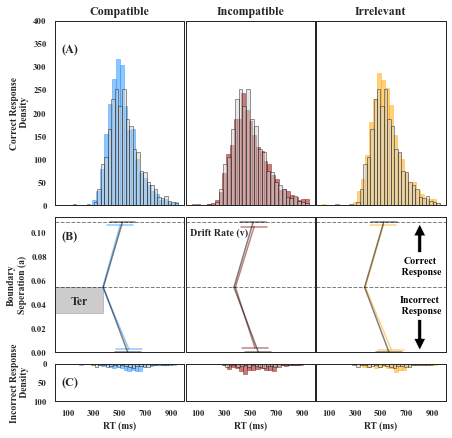

In [10]:
prpr.plot_diffusion()

In [11]:
rep = air.AIR(*dfs, **session_params)

C:\Users\Eitan Hemed\.conda\envs\pyr_env\lib\site-packages\rpy2\robjects\pandas2ri.py:67: UserWarning: Error while trying to convert the column "index". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
C:\Users\Eitan Hemed\.conda\envs\pyr_env\lib\site-packages\rpy2\robjects\pandas2ri.py:67: UserWarning: Error while trying to convert the column "participant". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
C:\Users\Eitan Hemed\.conda\envs\pyr_env\lib\site-packages\rpy2\robjects\pandas2ri.py:67: UserWarning: Error while trying to convert the column "condition". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
C:\Users\Eitan Hemed\.conda\envs\pyr_env\lib\site-packages\rpy2\robjects

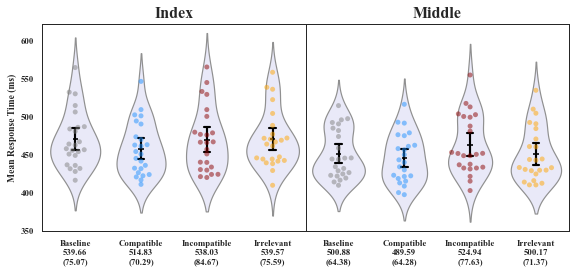

In [12]:
rep.plot_rt_by_fingers()

Repeated-Measures ANOVA showed a significant effect of experimental condition on Mean Response Time [F(2, 36) = 25.82, p < 0.001, Partial-η Squared = 0.529]
The Compatible condition Lower-tail t(23) = -5.15, p < 0.001, Mean Response Time Change -18.10ms, Cohen's d = -1.07 95%-CI [-1.57, -0.56], BF1:0 = 1487.170
The Incompatible condition Upper-tail t(23) = 2.56, p = 0.009, Mean Response Time Change 10.94ms, Cohen's d = 0.53 95%-CI [0.10, 0.96], BF1:0 = 5.980
The Irrelevant condition Two-tail t(23) = -0.25, p = 0.805, Mean Response Time Change -0.71ms, Cohen's d = -0.05 95%-CI [-0.45, 0.35], BF1:0 = 0.220


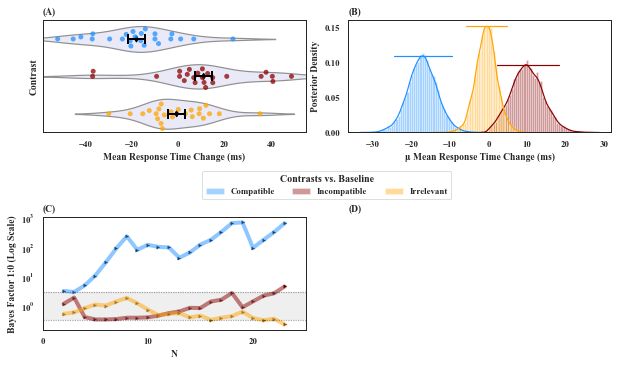

In [13]:
rep.report_results('rt')

Repeated-Measures ANOVA showed an insignificant effect of experimental condition on Error Rate [F(1, 25) = 0.81, p = 0.388, Partial-η Squared = 0.034]
The Compatible condition Lower-tail t(23) = 0.16, p = 0.564, Error Rate Change 0.08%, Cohen's d = 0.03 95%-CI [-0.37, 0.43], BF1:0 = 0.190
The Incompatible condition Upper-tail t(23) = 0.86, p = 0.199, Error Rate Change 1.58%, Cohen's d = 0.18 95%-CI [-0.23, 0.58], BF1:0 = 0.470
The Irrelevant condition Two-tail t(23) = 0.00, p = 1.000, Error Rate Change 0.00%, Cohen's d = 0.00 95%-CI [-0.40, 0.40], BF1:0 = 0.210


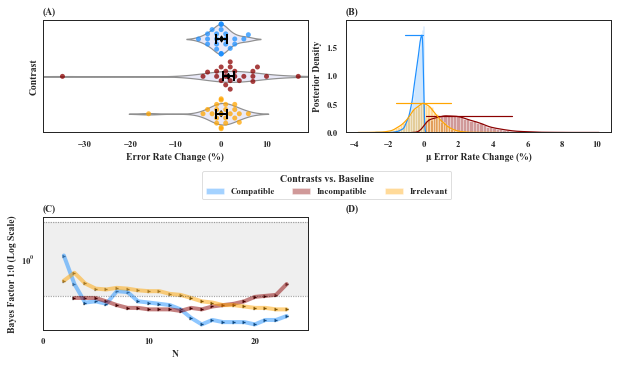

In [14]:
rep.report_results('er')

Repeated-Measures ANOVA showed a significant effect of experimental condition on Drift Rate [F(1, 27) = 6.71, p = 0.012, Partial-η Squared = 0.226]
The Compatible condition Upper-tail t(23) = 1.27, p = 0.108, Drift Rate Change 0.0132v, Cohen's d = 0.27 95%-CI [-0.14, 0.67], BF1:0 = 0.770
The Incompatible condition Lower-tail t(23) = -2.17, p = 0.020, Drift Rate Change -0.0332v, Cohen's d = -0.45 95%-CI [-0.87, -0.03], BF1:0 = 2.980
The Irrelevant condition Two-tail t(23) = -0.16, p = 0.875, Drift Rate Change -0.0015v, Cohen's d = -0.03 95%-CI [-0.43, 0.37], BF1:0 = 0.220


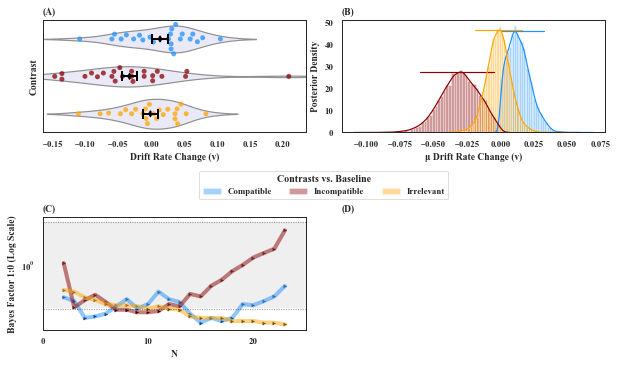

In [15]:
rep.report_results('drift_rate')

Repeated-Measures ANOVA showed an insignificant effect of experimental condition on Boundary Separation [F(2, 39) = 0.34, p = 0.680, Partial-η Squared = 0.015]
The Compatible condition Lower-tail t(23) = -1.77, p = 0.045, Boundary Separation Change -0.0050a, Cohen's d = -0.37 95%-CI [-0.78, 0.05], BF1:0 = 1.570
The Incompatible condition Upper-tail t(23) = -1.78, p = 0.956, Boundary Separation Change -0.0072a, Cohen's d = -0.37 95%-CI [-0.78, 0.05], BF1:0 = 0.090
The Irrelevant condition Two-tail t(23) = -1.67, p = 0.108, Boundary Separation Change -0.0043a, Cohen's d = -0.35 95%-CI [-0.76, 0.07], BF1:0 = 0.720


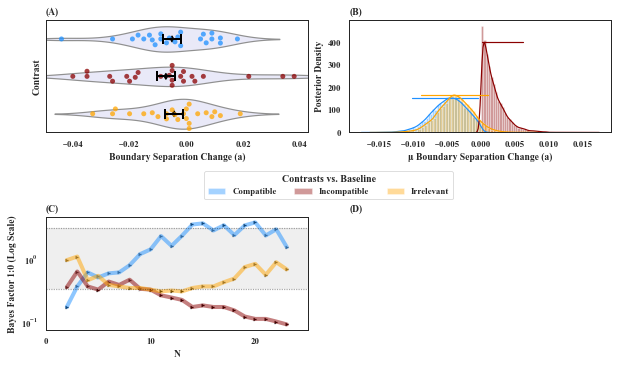

In [16]:
rep.report_results('boundary_separation')

Repeated-Measures ANOVA showed a significant effect of experimental condition on Non-Decision Time [F(2, 38) = 4.39, p = 0.025, Partial-η Squared = 0.160]
The Compatible condition Lower-tail t(23) = -0.98, p = 0.168, Non-Decision Time Change -0.0047s, Cohen's d = -0.20 95%-CI [-0.61, 0.20], BF1:0 = 0.540
The Incompatible condition Upper-tail t(23) = 2.01, p = 0.028, Non-Decision Time Change 0.0109s, Cohen's d = 0.42 95%-CI [-0.00, 0.83], BF1:0 = 2.290
The Irrelevant condition Two-tail t(23) = 1.89, p = 0.072, Non-Decision Time Change 0.0054s, Cohen's d = 0.39 95%-CI [-0.03, 0.81], BF1:0 = 0.980


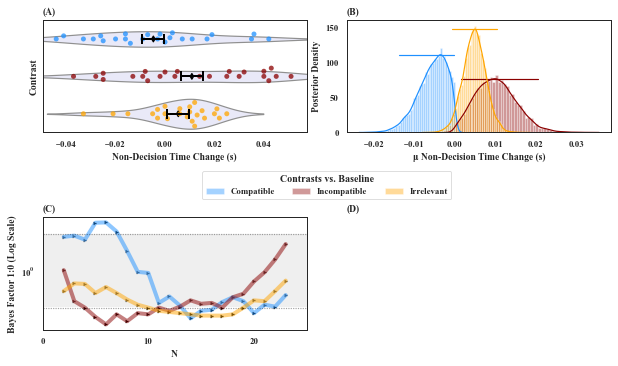

In [17]:
rep.report_results('non_decision_time')